# Extra datasets

Downloading/uploading extra datasets to Active Loop

Codebrim - https://zenodo.org/record/2620293

https://github.com/activeloopai/Hub

https://docs.activeloop.ai/hub-tutorials/creating-complex-datasets


## Setup

In [ ]:
!pip install hub urllib3==1.26.7 --quiet

     |████████████████████████████████| 407 kB 32.2 MB/s 
     |████████████████████████████████| 138 kB 72.0 MB/s 
     |████████████████████████████████| 132 kB 92.2 MB/s 
     |████████████████████████████████| 76 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 61.3 MB/s 
     |████████████████████████████████| 79 kB 10.3 MB/s 
     |████████████████████████████████| 9.1 MB 70.8 MB/s 
     |████████████████████████████████| 115 kB 90.2 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 


In [ ]:
import hub
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
from getpass import getpass
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET

In [ ]:
class_names = ["Background", "Crack", "Spallation", "Efflorescence", "ExposedBars", "CorrosionStain"]

## CODEBRIM Classification dataset

In [ ]:
!wget https://zenodo.org/record/2620293/files/CODEBRIM_classification_dataset.zip

--2022-08-14 13:45:57--  https://zenodo.org/record/2620293/files/CODEBRIM_classification_dataset.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7911716093 (7.4G) [application/octet-stream]
Saving to: ‘CODEBRIM_classification_dataset.zip’

CODEBRIM_classifica 100%[===================>]   7.37G  14.3MB/s    in 7m 20s  

2022-08-14 13:53:19 (17.1 MB/s) - ‘CODEBRIM_classification_dataset.zip’ saved [7911716093/7911716093]



In [ ]:
!jar xf CODEBRIM_classification_dataset.zip

In [ ]:
# https://github.com/MrtnMndt/meta-learning-CODEBRIM/blob/master/MetaQNN/lib/Datasets/datasets.py
########################
# importing libraries
########################
# system libraries
import numpy as np
import os
import torch
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import xml.etree.ElementTree as ElementTree


class CODEBRIMSplit(datasets.ImageFolder):
    """
    definition of class for reading data-split images and class labels, and iterating
    over the datapoints
    Parameters:
        root (string): directory path for the data split
        xml_list (list): list of paths to xmls for defect and background meta-data
        transform (torchvision.transforms.Compose): transforms for the input data
        target_transform (callable): transform for the targets
        loader (callable): for loading an image given its path
    Attributes:
        file_list (dictionary): dictionary of file names (keys) and the corresponding
                                class labels (values)
        num_classes (int): number of classes in the dataset (6)
    """
    def __init__(self, root, xml_list, transform=None, target_transform=None, loader=datasets.folder.default_loader):
        super(CODEBRIMSplit, self).__init__(root, transform, target_transform, loader)
        self.file_list = {}
        self.num_classes = 6
        for file_name in xml_list:
            last_dot_idx = file_name.rfind('.')
            f_name_idx = file_name.rfind('/')
            root_path = file_name[f_name_idx + 1: last_dot_idx]
            tree = ElementTree.parse(file_name)
            root = tree.getroot()
            for defect in root:
                crop_name = list(defect.attrib.values())[0]
                target = self.compute_target_multi_target(defect)
                self.file_list[os.path.join(root_path, crop_name)] = target

    def __getitem__(self, idx):
        """
        defines the iterator for the dataset and returns datapoints in the form of tuples
        Parameters:
            idx (int): index to return the datapoint from
        Returns:
            a datapoint tuple (sample, target) for the index
        """
        image_batch = super(CODEBRIMSplit, self).__getitem__(idx)[0]
        image_name = self.imgs[idx][0]
        f_name_idx = image_name.rfind('/')
        f_dir_idx = image_name[: f_name_idx].rfind('/')
        de_lim = image_name.rfind('_-_')
        file_type = image_name.rfind('.')
        if de_lim != -1:
            name = image_name[f_dir_idx + 1: de_lim] + image_name[file_type:]
        else:
            name = image_name[f_dir_idx + 1:]
        return [image_batch, self.file_list[name]]

    def compute_target_multi_target(self, defect):
        """
        enumerates the class-label by defining a float32 numpy array
        Parameters:
            defect (string): the class labels in the form of a string
        Returns:
            the enumerated version of the labels in the form of a numpy array 
        """
        out = np.zeros(self.num_classes, dtype=np.float32)
        for i in range(self.num_classes):
            if defect[i].text == '1':
                out[i] = 1.0
        return out


class CODEBRIM:
    """
    definition of CODEBRIM dataset, train/val/test splits, train/val/test loaders
    Parameters:
        args (argparse.Namespace): parsed command line arguments
        is_gpu (bool): if computational device is gpu or cpu
    Attributes:
        num_classes (int): number of classes in the dataset (= 6)
        dataset_path (string): path to dataset folder
        dataset_xml_list (list): list to dataset meta-data
        train_set (CODEBRIMSplit): train split
        val_set (CODEBRIMSplit): validation split
        test_set (CODEBRIMSplit): test split
        train_loader (torch.utils.data.DataLoader): data-loader for train-split
        val_loader (torch.utils.data.DataLoader): data-loader for val-split
        test_loader (torch.utils.data.DataLoader): data-loader for test-split
    """
    def __init__(self, is_gpu, args):
        self.num_classes = 6
        self.dataset_path = args.dataset_path
        self.dataset_xml_list = [os.path.join(args.dataset_path, 'metadata/background.xml'),
                                 os.path.join(args.dataset_path, 'metadata/defects.xml')]
        self.train_set, self.val_set, self.test_set = self.get_dataset(args.patch_size)
        self.train_loader, self.val_loader, self.test_loader = self.get_dataset_loader(args.batch_size, args.workers,
                                                                                       is_gpu)

    def get_dataset(self, patch_size):
        """
        return dataset splits
        Parameters:
            patch_size (int): patch-size to rescale the images to
        
        Returns:
            train_set, val_set, test_set of type lib.Datasets.datasets.CODEBRIMSplit
        """

        train_tf = transforms.Compose([transforms.Resize(patch_size),
                                        # transforms.RandomCrop(patch_size),
                                        # transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()])
        val_tf = transforms.Compose([transforms.Resize(patch_size),
                                                        #transforms.CenterCrop(patch_size),
                                                        transforms.ToTensor()])

        test_tf = transforms.Compose([transforms.Resize(patch_size),
                                                        #transforms.CenterCrop(patch_size),
                                                        transforms.ToTensor()])

        train_set = CODEBRIMSplit(os.path.join(self.dataset_path, 'train'),
                                  self.dataset_xml_list,
                                  transform=train_tf)
        val_set = CODEBRIMSplit(os.path.join(self.dataset_path, 'val'),
                                self.dataset_xml_list,
                                transform=val_tf)
        test_set = CODEBRIMSplit(os.path.join(self.dataset_path, 'test'),
                                 self.dataset_xml_list,
                                 transform=test_tf)
        
        return train_set, val_set, test_set

    def get_dataset_loader(self, batch_size, workers, is_gpu):
        """
        defines the dataset loader for wrapped dataset
        Parameters:
            batch_size (int): mini batch size in data loader
            workers (int): number of parallel cpu threads for data loading
            is_gpu (bool): True if CUDA is enabled so pin_memory is set to True
        
        Returns:
            train_loader, val_loader, test_loader of type torch.utils.data.DataLoader
        """
        train_loader = torch.utils.data.DataLoader(self.train_set, num_workers=workers, batch_size=batch_size,
                                                   shuffle=True, pin_memory=is_gpu)
        val_loader = torch.utils.data.DataLoader(self.val_set, num_workers=workers, batch_size=batch_size,
                                                 shuffle=False, pin_memory=is_gpu)
        test_loader = torch.utils.data.DataLoader(self.test_set, num_workers=workers, batch_size=batch_size,
                                                  shuffle=False, pin_memory=is_gpu)

        return train_loader, val_loader, test_loader

```
<Defect name="image_0000005_crop_0000002.png">
    <Background>0</Background>
    <Crack>0</Crack>
    <Spallation>0</Spallation>
    <Efflorescence>1</Efflorescence>
    <ExposedBars>0</ExposedBars>
    <CorrosionStain>1</CorrosionStain>
</Defect>
```

In [ ]:
class_names = ["Background", "Crack", "Spallation", "Efflorescence", "ExposedBars", "CorrosionStain"]

In [ ]:
class args:
    dataset_path = "./classification_dataset"
    patch_size = 256
    batch_size = 8
    workers = 0

codebrim = CODEBRIM(is_gpu=False, args=args)

In [ ]:
train_ds, val_ds, test_ds = codebrim.get_dataset((args.patch_size, args.patch_size))

[1. 0. 0. 0. 0. 0.]


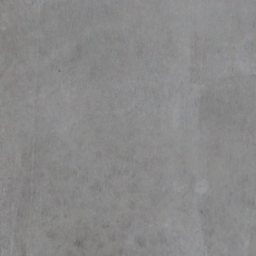

In [ ]:
from PIL import Image
label = train_ds[0][1]
x = train_ds[0][0].numpy()
x = np.transpose(x, (1, 2, 0))
img = Image.fromarray((x * 255).astype(np.uint8))
print(label)
img

In [ ]:
for split, curr_ds in zip(["train", "val", "test"], [train_ds, val_ds, test_ds]):
    print(split)
    data_url = f"hub://luizapzbn/CODEBRIM_classification_dataset-{split}"
    ds = hub.empty(data_url, token=getpass(prompt='Token: ', stream=None)) # Create the dataset

    with ds:
        # Image
        ds.create_tensor('images', htype='image', sample_compression='jpeg')
        
        # Classification
        ds.create_tensor('labels', htype='class_label', class_names = class_names)

    with ds:
        #Iterate throgh the images
        for img, label in tqdm(curr_ds):
            # Get the class number for the classification
            img = (img.numpy() * 255).astype(np.uint8)
            img = np.transpose(img, (1, 2, 0))
            label_idx = np.argmax(label)
            # Append data to tensors
            ds.append({'images': img,
                    'labels': np.uint32(label_idx),
            })

train
Token: ··········
Your Hub dataset has been successfully created!
The dataset is private so make sure you are logged in!
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-train


  0%|          | 0/6481 [00:00<?, ?it/s]

val
Token: ··········
Your Hub dataset has been successfully created!
The dataset is private so make sure you are logged in!
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-val


  0%|          | 0/616 [00:00<?, ?it/s]

test
Token: ··········
Your Hub dataset has been successfully created!
The dataset is private so make sure you are logged in!
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-test


  0%|          | 0/632 [00:00<?, ?it/s]

In [ ]:
ds = hub.load(data_url)

hub://luizapzbn/CODEBRIM_classification_dataset-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-test


Background


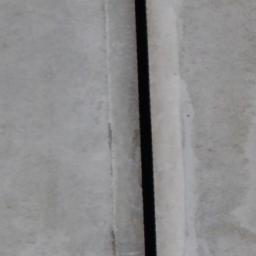

In [ ]:
ind = 1
img = Image.fromarray(ds.images[ind].numpy())
label = class_names[ds.labels[ind].numpy()[0]]
print(label)
img

## CODEBRIM Object Detection

https://www.kaggle.com/code/mtszkw/reading-sample-image-and-bounding-boxes-from-xml

In [ ]:
!wget https://zenodo.org/record/2620293/files/CODEBRIM_original_images.zip

--2022-08-26 11:20:38--  https://zenodo.org/record/2620293/files/CODEBRIM_original_images.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8310630622 (7.7G) [application/octet-stream]
Saving to: ‘CODEBRIM_original_images.zip’

CODEBRIM_original_i 100%[===================>]   7.74G  5.76MB/s    in 19m 31s 

2022-08-26 11:40:10 (6.77 MB/s) - ‘CODEBRIM_original_images.zip’ saved [8310630622/8310630622]



In [ ]:
!jar xf CODEBRIM_original_images.zip

In [ ]:
from pathlib import Path
annt_dir = Path("/content/original_dataset/annotations/")
images_dir = Path("/content/original_dataset/images/")

In [ ]:
data_url = f"hub://luizapzbn/CODEBRIM_original_images_od"
ds = hub.empty(data_url, token=getpass(prompt='Token: ', stream=None)) # Create the dataset

with ds:
    # Image
    ds.create_tensor('images', htype='image', sample_compression='jpeg')
    
    # Boxes
    ds.create_tensor('boxes/bbox', htype='bbox')
    ds.create_tensor('boxes/labels', htype='class_label', class_names=class_names)

Token: ··········
Your Hub dataset has been successfully created!
The dataset is private so make sure you are logged in!
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_original_images_od


In [ ]:
for i, ant_path in enumerate(tqdm(annt_dir.glob("*.xml"))):

    if i <= 10:
        continue

    tree = ET.parse(ant_path)
    root = tree.getroot()

    filename = root.find("filename").text
    img = Image.open(images_dir / filename)

    bboxes = []
    defects = []
    for neighbor in root.iter('bndbox'):
        xmin = int(neighbor.find('xmin').text)
        ymin = int(neighbor.find('ymin').text)
        xmax = int(neighbor.find('xmax').text)
        ymax = int(neighbor.find('ymax').text)

        bboxes.append([xmin, ymin, xmax, ymax])

    for neighbor in root.iter('Defect'):
        bg = int(neighbor.find("Background").text)
        cr = int(neighbor.find("Crack").text)
        sp = int(neighbor.find("Spallation").text)
        ef = int(neighbor.find("Efflorescence").text)
        eb = int(neighbor.find("ExposedBars").text)
        cs = int(neighbor.find("CorrosionStain").text)

        defs = np.array([bg, cr, sp, ef, eb, cs])
        defects.append(defs)

    if len(defects) == 0:
        defects = [defects]
    if len(bboxes) == 0:
        bboxes = [bboxes]

    defects = np.array(defects).astype(np.uint32)
    bboxes = np.array(bboxes).astype(np.float32)
    img = (np.array(img) * 255).astype(np.uint8)

    ds_dict = {
        'images': img,
        'boxes/bbox': bboxes,
        'boxes/labels': defects,
    }

    with ds:
        ds.append(ds_dict)

0it [00:00, ?it/s]

In [ ]:
!wget https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf

--2022-08-26 12:10:22--  https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf [following]
--2022-08-26 12:10:23--  https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275572 (269K) [application/octet-stream]
Saving to: ‘Arial.ttf’

Arial.ttf           100%[===================>] 269.11K  --.-KB/s    in 0.005s  

2022-08-26 12:10:23 (57.8 MB/s) - ‘Arial.ttf’ saved [275572/275572]



In [ ]:
ds = hub.load(data_url, token=getpass(prompt='Token: ', stream=None))

Token: ··········
hub://luizapzbn/CODEBRIM_original_images_od loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_original_images_od


In [ ]:
sample = ds[159]
image = sample["images"].numpy()
labels = sample["boxes/labels"].numpy()
bboxes = sample["boxes/bbox"].numpy()

In [ ]:
sample_image = Image.fromarray(image)
sample_image_annotated = sample_image.copy()

img_bbox = ImageDraw.Draw(sample_image_annotated)
font = ImageFont.truetype("/content/Arial.ttf", 64)

for bbox, bbox_labels in zip(bboxes, labels):
    labels_text = ', '.join([class_names[idx] for idx in np.where(bbox_labels)[0]])
    img_bbox.rectangle(bbox, outline="green", width=5) 
    img_bbox.text((bbox[0], bbox[1]), labels_text, font=font)

sample_image_annotated